**Import Libraries**

In [1]:
# Standard Libraries
import os
import copy
import random
from glob import glob
from PIL import Image

# Data Manipulation Libraries
import pandas as pd
import numpy as np

# Visualization Libraries
import matplotlib.pyplot as plt

# Progress Bar
from tqdm import tqdm

# Machine Learning Libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models
from sklearn.model_selection import train_test_split
from lightly.loss import NTXentLoss
from lightly.transforms.byol_transform import BYOLTransform, BYOLView1Transform, BYOLView2Transform
from lightly.models.modules import BYOLProjectionHead, BYOLPredictionHead
from lightly.models.utils import deactivate_requires_grad, update_momentum
from lightly.loss import NegativeCosineSimilarity
from lightly.utils.scheduler import cosine_schedule
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc, f1_score

/cluster/home/bjorneme/.conda/envs/master_thesis/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


**Define Parameters**

In [2]:
# Paths
ZIP_PATH = '/cluster/home/bjorneme/projects/Data/chestX-ray14.zip'
EXTRACTED_PATH = '/cluster/home/bjorneme/projects/Data/chestX-ray14-extracted'

# Define parameters
SEED = 42

# Parameteres fine tuning
LEARNING_RATE = 1e-4
EPOCHS = 100
BATCH_SIZE = 64

# Device Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


**Set Seed for Reproducibility**

In [3]:
def seed_everything(seed=SEED):
    """
    Sets the seed to ensure reproducibility.
    """
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    # Ensure deterministic behavior in CUDA operations
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Apply the seed
seed_everything()

# **Step 1: Load Data**

In [4]:
def extract_data(zip_path, extracted_path):
    """
    Extracts the ZIP file of the dataset.
    """
    os.makedirs(extracted_path, exist_ok=True)
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extracted_path)
    print(f"Data extracted to {extracted_path}")

# Uncomment the line below to extract data (if not already extracted)
# extract_data(ZIP_PATH, EXTRACTED_PATH)

# **Step 2: Data Preprocessing**

In [5]:
# Define Disease Labels
disease_labels = [
    'Atelectasis', 'Consolidation', 'Infiltration', 'Pneumothorax', 'Edema',
    'Emphysema', 'Fibrosis', 'Effusion', 'Pneumonia', 'Pleural_Thickening',
    'Cardiomegaly', 'Nodule', 'Mass', 'Hernia'
]

def load_labels(csv_path, image_path):
    """
    Loads and preprocesses the labels from the CSV file.
    Maps each image to its corresponding file path and binary labels for each disease.
    """

    # Read the CSV file containing labels
    labels_df = pd.read_csv(csv_path)

    # Create binary columns for each disease label
    for disease in disease_labels:
        labels_df[disease] = labels_df['Finding Labels'].str.contains(disease).astype(int)

    # Create a binary column for 'No Finding'
    labels_df['No_Finding'] = labels_df['Finding Labels'].apply(lambda x: 1 if 'No Finding' in x else 0)

    # Map image filenames to their full paths
    image_paths = glob(os.path.join(image_path, '**', 'images', '*.png'), recursive=True)
    img_path_dict = {os.path.basename(path): path for path in image_paths}

    # Add the full image path to the dataframe
    labels_df['Path'] = labels_df['Image Index'].map(img_path_dict)
    return labels_df

# Path to the labels CSV file
labels_csv_path = os.path.join(EXTRACTED_PATH, 'Data_Entry_2017.csv')

# Load and preprocess the labels
labels_df = load_labels(labels_csv_path, EXTRACTED_PATH)

**Split Dataset**

In [6]:
# Split patients into training/validation and test sets
unique_patients = labels_df['Patient ID'].unique()
train_val_patients, test_patients = train_test_split(
    unique_patients, test_size=0.2, random_state=SEED
)

# Create training/validation and test dataframes
train_val_df = labels_df[labels_df['Patient ID'].isin(train_val_patients)].reset_index(drop=True)
test_df = labels_df[labels_df['Patient ID'].isin(test_patients)].reset_index(drop=True)

# Verify Split Sizes
print(f"Train size: {train_val_df.shape[0]}")
print(f"Test size: {test_df.shape[0]}")

Train size: 89826
Test size: 22294


# **Step 6: Data Processing Part 2**

**Define Dataset for ChestX-ray14 images**

In [7]:
class ChestXrayDataset(Dataset):
    """
    Custom Dataset for ChestX-ray14 images.
    """
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df) # TODO

    def __getitem__(self, idx):
        # Get image path and labels
        img_path = self.df.iloc[idx]['Path']
        image = plt.imread(img_path)
        label = self.df.iloc[idx][disease_labels].values.astype(np.float32)
        
        # Apply transformations if any
        if self.transform:
            image = self.transform(image)
        
        return image, label

**Define Data Transformations**

In [8]:
# Define transformations for training data
train_transforms = transforms.Compose([

    # Convert image to PIL format for further transformations
    transforms.ToPILImage(),

    # Convert to grayscale and change to 3 channels
    transforms.Grayscale(num_output_channels=3),

    # Resize the image to 224x224
    transforms.Resize((224, 224)),

    # Apply random horizontal flip to augment the data
    transforms.RandomHorizontalFlip(),

    # Randomly rotate the image within a range of ±10 degrees
    transforms.RandomRotation(10),

    # Convert the image to a PyTorch tensor
    transforms.ToTensor(),

    # Normalize using ImageNet mean and std
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Define transformations for test data
test_transforms = transforms.Compose([

    # Convert image to PIL format for further transformations
    transforms.ToPILImage(),

    # Convert to grayscale and change to 3 channels
    transforms.Grayscale(num_output_channels=3),

    # Resize the image to 224x224
    transforms.Resize((224, 224)),

    # Convert the image to a PyTorch tensor
    transforms.ToTensor(),

    # Normalize using ImageNet mean and std
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

**Create Datasets**

In [9]:
train_dataset = ChestXrayDataset(train_val_df, transform=train_transforms)
test_dataset = ChestXrayDataset(test_df, transform=test_transforms)

**Split into Training and Validation**

In [10]:
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

**Create DataLoaders**

In [11]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=64)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=64)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=64)

/cluster/home/bjorneme/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 64 worker processes in total. Our suggested max number of worker in current system is 32, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [12]:
pip install byol-pytorch

Note: you may need to restart the kernel to use updated packages.


In [13]:
from byol_pytorch import BYOL

In [14]:
# Initialize your backbone
resnet = models.densenet121(weights=models.DenseNet121_Weights.IMAGENET1K_V1)
resnet.to(device)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [15]:
learner = BYOL(
    resnet,
    image_size=224,
    hidden_layer='features'
)

optimizer = optim.Adam(learner.parameters(), lr=3e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=True)

# Early stopping parameters
patience = 5
best_loss = float('inf')
epochs_without_improvement = 0

for epoch in range(EPOCHS):
    epoch_loss = 0.0
    batch_count = 0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}")
    for batch in progress_bar:
        images = batch[0].to(device)
        loss = learner(images)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        learner.update_moving_average()
        
        # Update tracking variables
        epoch_loss += loss.item()
        batch_count += 1
        progress_bar.set_postfix({"Loss": loss.item()})
    
    avg_loss = epoch_loss / batch_count
    print(f"Epoch {epoch+1} average loss: {avg_loss:.4f}")
    
    # Update the learning rate scheduler with the average loss
    scheduler.step(avg_loss)
    
    # Early stopping check
    if avg_loss < best_loss:
        best_loss = avg_loss
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1
        if epochs_without_improvement >= patience:
            print(f"No improvement for {patience} consecutive epochs. Early stopping...")
            break

Epoch 1/100:   0%|          | 0/1123 [00:00<?, ?it/s]/cluster/home/bjorneme/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 64 worker processes in total. Our suggested max number of worker in current system is 32, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 1/100: 100%|██████████| 1123/1123 [05:55<00:00,  3.16it/s, Loss=0.807] 


Epoch 1 average loss: 0.4563


Epoch 2/100: 100%|██████████| 1123/1123 [05:55<00:00,  3.16it/s, Loss=1.34]  


Epoch 2 average loss: 0.1641


Epoch 3/100: 100%|██████████| 1123/1123 [05:54<00:00,  3.17it/s, Loss=0.00935]


Epoch 3 average loss: 0.1383


Epoch 4/100: 100%|██████████| 1123/1123 [05:54<00:00,  3.17it/s, Loss=0.00956]


Epoch 4 average loss: 0.1458


Epoch 5/100: 100%|██████████| 1123/1123 [05:53<00:00,  3.17it/s, Loss=0.158]  


Epoch 5 average loss: 0.1281


Epoch 6/100: 100%|██████████| 1123/1123 [05:54<00:00,  3.17it/s, Loss=0.185]  


Epoch 6 average loss: 0.0895


Epoch 7/100: 100%|██████████| 1123/1123 [09:46<00:00,  1.92it/s, Loss=0.0285] 


Epoch 7 average loss: 0.1155


Epoch 8/100: 100%|██████████| 1123/1123 [09:37<00:00,  1.95it/s, Loss=0.00752]


Epoch 8 average loss: 0.1133


Epoch 9/100: 100%|██████████| 1123/1123 [05:54<00:00,  3.16it/s, Loss=0.328]  


Epoch 9 average loss: 0.0874


Epoch 10/100: 100%|██████████| 1123/1123 [08:37<00:00,  2.17it/s, Loss=0.00954]


Epoch 10 average loss: 0.0798


Epoch 11/100: 100%|██████████| 1123/1123 [09:41<00:00,  1.93it/s, Loss=0.0527] 


Epoch 11 average loss: 0.0845


Epoch 12/100: 100%|██████████| 1123/1123 [10:17<00:00,  1.82it/s, Loss=0.0107] 


Epoch 12 average loss: 0.0756


Epoch 13/100: 100%|██████████| 1123/1123 [10:49<00:00,  1.73it/s, Loss=0.0105] 


Epoch 13 average loss: 0.0676


Epoch 14/100: 100%|██████████| 1123/1123 [10:50<00:00,  1.73it/s, Loss=0.0109] 


Epoch 14 average loss: 0.0608


Epoch 15/100: 100%|██████████| 1123/1123 [10:56<00:00,  1.71it/s, Loss=0.0104] 


Epoch 15 average loss: 0.0850


Epoch 16/100: 100%|██████████| 1123/1123 [10:33<00:00,  1.77it/s, Loss=0.0623] 


Epoch 16 average loss: 0.0704


Epoch 17/100: 100%|██████████| 1123/1123 [10:13<00:00,  1.83it/s, Loss=0.0264] 


Epoch 17 average loss: 0.0510


Epoch 18/100: 100%|██████████| 1123/1123 [10:45<00:00,  1.74it/s, Loss=0.00733]


Epoch 18 average loss: 0.0606


Epoch 19/100: 100%|██████████| 1123/1123 [10:46<00:00,  1.74it/s, Loss=0.00855]


Epoch 19 average loss: 0.0619


Epoch 20/100: 100%|██████████| 1123/1123 [10:46<00:00,  1.74it/s, Loss=0.0106] 


Epoch 20 average loss: 0.0606


Epoch 21/100: 100%|██████████| 1123/1123 [07:38<00:00,  2.45it/s, Loss=0.0586] 


Epoch 21 average loss: 0.0522


Epoch 22/100: 100%|██████████| 1123/1123 [08:07<00:00,  2.31it/s, Loss=0.0851] 


Epoch 22 average loss: 0.0411


Epoch 23/100: 100%|██████████| 1123/1123 [10:26<00:00,  1.79it/s, Loss=0.0184] 


Epoch 23 average loss: 0.0436


Epoch 24/100: 100%|██████████| 1123/1123 [10:44<00:00,  1.74it/s, Loss=0.0212] 


Epoch 24 average loss: 0.0351


Epoch 25/100: 100%|██████████| 1123/1123 [10:51<00:00,  1.72it/s, Loss=0.0151] 


Epoch 25 average loss: 0.0359


Epoch 26/100: 100%|██████████| 1123/1123 [10:55<00:00,  1.71it/s, Loss=0.011]  


Epoch 26 average loss: 0.0344


Epoch 27/100: 100%|██████████| 1123/1123 [11:29<00:00,  1.63it/s, Loss=0.0379] 


Epoch 27 average loss: 0.0347


Epoch 28/100: 100%|██████████| 1123/1123 [11:32<00:00,  1.62it/s, Loss=0.0171] 


Epoch 28 average loss: 0.0303


Epoch 29/100: 100%|██████████| 1123/1123 [11:36<00:00,  1.61it/s, Loss=0.0102] 


Epoch 29 average loss: 0.0306


Epoch 30/100: 100%|██████████| 1123/1123 [11:35<00:00,  1.62it/s, Loss=0.0142] 


Epoch 30 average loss: 0.0320


Epoch 31/100: 100%|██████████| 1123/1123 [11:36<00:00,  1.61it/s, Loss=0.0305] 


Epoch 31 average loss: 0.0277


Epoch 32/100: 100%|██████████| 1123/1123 [10:00<00:00,  1.87it/s, Loss=0.0322] 


Epoch 32 average loss: 0.0304


Epoch 33/100: 100%|██████████| 1123/1123 [05:54<00:00,  3.17it/s, Loss=0.003]  


Epoch 33 average loss: 0.0251


Epoch 34/100: 100%|██████████| 1123/1123 [05:56<00:00,  3.15it/s, Loss=0.00409]


Epoch 34 average loss: 0.0275


Epoch 35/100: 100%|██████████| 1123/1123 [05:58<00:00,  3.13it/s, Loss=0.004]  


Epoch 35 average loss: 0.0276


Epoch 36/100: 100%|██████████| 1123/1123 [05:54<00:00,  3.16it/s, Loss=0.00876]


Epoch 36 average loss: 0.0260


Epoch 37/100: 100%|██████████| 1123/1123 [05:55<00:00,  3.16it/s, Loss=0.0177] 


Epoch 37 average loss: 0.0275


Epoch 38/100: 100%|██████████| 1123/1123 [05:54<00:00,  3.17it/s, Loss=0.078]  


Epoch 38 average loss: 0.0245


Epoch 39/100: 100%|██████████| 1123/1123 [05:55<00:00,  3.16it/s, Loss=0.066]  


Epoch 39 average loss: 0.0235


Epoch 40/100: 100%|██████████| 1123/1123 [05:54<00:00,  3.17it/s, Loss=0.00367]


Epoch 40 average loss: 0.0261


Epoch 41/100: 100%|██████████| 1123/1123 [05:54<00:00,  3.17it/s, Loss=0.00217]


Epoch 41 average loss: 0.0249


Epoch 42/100: 100%|██████████| 1123/1123 [05:54<00:00,  3.16it/s, Loss=0.00797]


Epoch 42 average loss: 0.0237


Epoch 43/100: 100%|██████████| 1123/1123 [05:59<00:00,  3.13it/s, Loss=0.0655] 


Epoch 43 average loss: 0.0261


Epoch 44/100: 100%|██████████| 1123/1123 [05:55<00:00,  3.16it/s, Loss=0.0309] 

Epoch 44 average loss: 0.0256
No improvement for 5 consecutive epochs. Early stopping...


# **Step 7: Build the Model**

**Initialize the Multi-Label Classifier Model**

In [16]:
# Define the model
class MultiLabelClassifier(nn.Module):
    """
    Multi-Label Classification Model using Swin Transformer as the base model.
    """
    def __init__(self, backbone, num_classes=len(disease_labels)):
        super(MultiLabelClassifier, self).__init__()

        # Load pre-trained Swin Transformer model
        self.base_model = backbone

        # Replace the classification head to match the number of disease labels
        self.base_model.classifier = nn.Linear(self.base_model.classifier.in_features, num_classes)

    def forward(self, x):
        return self.base_model(x)

# Initialize the Model
model = MultiLabelClassifier(backbone=resnet)
model.to(device)

MultiLabelClassifier(
  (base_model): DenseNet(
    (features): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-

**Use Multiple GPUs**

In [17]:
model = nn.DataParallel(model)

**Define Loss Function and Optimizer**

In [18]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# **Step 8: Train the Model**

In [19]:
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10):

    """
    Trains the model and evaluates it on the validation set after each epoch.
    """
    # List to store loss and AUC
    train_losses = []
    val_losses = []
    val_aucs = []

    # Early stopping parameters
    patience = 5
    best_loss = 0
    epochs_without_improvement = 0

    for epoch in range(epochs):

        # Training
        model.train()
        train_loss = 0.0

        # Progress bar
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")

        for inputs, labels in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)

            # Clear gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)

            # Compute loss
            loss = criterion(outputs, labels)

            # Backward pass
            loss.backward()

            # Update weights
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)
            progress_bar.set_postfix({"Loss": loss.item()})

        # Calculate average training loss
        train_loss /= len(train_loader.dataset)
        train_losses.append(train_loss)

        # Validation
        model.eval()
        val_loss = 0.0
        all_labels = []
        all_preds = []

        # Progress bar
        progress_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs}")

        # Disable gradients for evaluation
        with torch.no_grad():
            for inputs, labels in progress_bar:
                inputs, labels = inputs.to(device), labels.to(device)

                # Forward pass
                outputs = model(inputs)

                # Compute loss
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)

                # Apply sigmoid
                preds = torch.sigmoid(outputs).cpu()

                # Store predictions and true labels
                all_preds.append(preds)
                all_labels.append(labels.cpu())
                
                progress_bar.set_postfix({"Loss": loss.item()})

        # Calculate average validation loss
        val_loss /= len(val_loader.dataset)
        val_losses.append(val_loss)

        # Concatenate all batches
        preds = torch.cat(all_preds)
        labels = torch.cat(all_labels)
    
        roc_auc_per_label = []

        # Compute metrics for each label
        for i, label in enumerate(disease_labels):

            # Calculate ROC AUC
            roc_auc = roc_auc_score(labels[:, i].numpy(), preds[:, i].numpy())
            roc_auc_per_label.append(roc_auc)

        # Calculate and add overall metrics
        mean_auc = np.mean(roc_auc_per_label)
        val_aucs.append(mean_auc)

        # Early stopping check
        if mean_auc > best_loss:
            best_loss = mean_auc
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement >= patience:
                print(f"No improvement for {patience} consecutive epochs. Early stopping...")
                break
        
        print(f"Epoch {epoch+1}/{epochs} | Training Loss: {train_loss:.4f} | "
              f"Validation Loss: {val_loss:.4f} | Mean Validation AUC: {mean_auc:.4f}")

    return train_losses, val_losses, val_aucs

# Train the model for the desired number of epochs
train_losses, val_losses, val_aucs = train_model(model, train_loader, val_loader, criterion, optimizer, epochs=EPOCHS)

Epoch 1/100:  19%|█▊        | 209/1123 [00:34<01:47,  8.47it/s, Loss=0.179]

Epoch 1/100: 100%|██████████| 281/281 [00:31<00:00,  8.87it/s, Loss=0.15] 


Epoch 1/100 | Training Loss: 0.1769 | Validation Loss: 0.1595 | Mean Validation AUC: 0.7598


Epoch 2/100:   0%|          | 0/1123 [00:00<?, ?it/s]/cluster/home/bjorneme/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 64 worker processes in total. Our suggested max number of worker in current system is 32, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 2/100: 100%|██████████| 281/281 [00:20<00:00, 13.51it/s, Loss=0.154]


Epoch 2/100 | Training Loss: 0.1580 | Validation Loss: 0.1546 | Mean Validation AUC: 0.7902


Epoch 3/100:   0%|          | 0/1123 [00:00<?, ?it/s]/cluster/home/bjorneme/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 64 worker processes in total. Our suggested max number of worker in current system is 32, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 3/100: 100%|██████████| 281/281 [00:20<00:00, 13.57it/s, Loss=0.144]


Epoch 3/100 | Training Loss: 0.1540 | Validation Loss: 0.1521 | Mean Validation AUC: 0.8032


Epoch 4/100:   0%|          | 0/1123 [00:00<?, ?it/s]/cluster/home/bjorneme/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 64 worker processes in total. Our suggested max number of worker in current system is 32, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 4/100: 100%|██████████| 281/281 [00:20<00:00, 13.70it/s, Loss=0.147] 


Epoch 4/100 | Training Loss: 0.1509 | Validation Loss: 0.1502 | Mean Validation AUC: 0.8126


Epoch 5/100:   0%|          | 0/1123 [00:00<?, ?it/s]/cluster/home/bjorneme/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 64 worker processes in total. Our suggested max number of worker in current system is 32, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 5/100: 100%|██████████| 281/281 [00:20<00:00, 13.71it/s, Loss=0.145] 


Epoch 5/100 | Training Loss: 0.1488 | Validation Loss: 0.1496 | Mean Validation AUC: 0.8163


Epoch 6/100:   0%|          | 0/1123 [00:00<?, ?it/s]/cluster/home/bjorneme/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 64 worker processes in total. Our suggested max number of worker in current system is 32, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 6/100: 100%|██████████| 281/281 [00:20<00:00, 13.66it/s, Loss=0.145] 


Epoch 6/100 | Training Loss: 0.1468 | Validation Loss: 0.1485 | Mean Validation AUC: 0.8204


Epoch 7/100:   0%|          | 0/1123 [00:00<?, ?it/s]/cluster/home/bjorneme/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 64 worker processes in total. Our suggested max number of worker in current system is 32, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 7/100: 100%|██████████| 281/281 [00:20<00:00, 13.51it/s, Loss=0.151]


Epoch 7/100 | Training Loss: 0.1450 | Validation Loss: 0.1484 | Mean Validation AUC: 0.8247


Epoch 8/100:   0%|          | 0/1123 [00:00<?, ?it/s]/cluster/home/bjorneme/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 64 worker processes in total. Our suggested max number of worker in current system is 32, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 8/100: 100%|██████████| 281/281 [00:20<00:00, 13.62it/s, Loss=0.149] 


Epoch 8/100 | Training Loss: 0.1435 | Validation Loss: 0.1476 | Mean Validation AUC: 0.8244


Epoch 9/100:   0%|          | 0/1123 [00:00<?, ?it/s]/cluster/home/bjorneme/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 64 worker processes in total. Our suggested max number of worker in current system is 32, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 9/100: 100%|██████████| 281/281 [00:20<00:00, 13.50it/s, Loss=0.156] 


Epoch 9/100 | Training Loss: 0.1418 | Validation Loss: 0.1475 | Mean Validation AUC: 0.8266


Epoch 10/100:   0%|          | 0/1123 [00:00<?, ?it/s]/cluster/home/bjorneme/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 64 worker processes in total. Our suggested max number of worker in current system is 32, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 10/100: 100%|██████████| 281/281 [00:20<00:00, 13.51it/s, Loss=0.145] 


Epoch 10/100 | Training Loss: 0.1403 | Validation Loss: 0.1471 | Mean Validation AUC: 0.8267


Epoch 11/100:   0%|          | 0/1123 [00:00<?, ?it/s]/cluster/home/bjorneme/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 64 worker processes in total. Our suggested max number of worker in current system is 32, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 11/100: 100%|██████████| 281/281 [00:20<00:00, 13.60it/s, Loss=0.152] 


Epoch 11/100 | Training Loss: 0.1384 | Validation Loss: 0.1474 | Mean Validation AUC: 0.8304


Epoch 12/100:   0%|          | 0/1123 [00:00<?, ?it/s]/cluster/home/bjorneme/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 64 worker processes in total. Our suggested max number of worker in current system is 32, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 12/100: 100%|██████████| 281/281 [00:20<00:00, 13.53it/s, Loss=0.141]


Epoch 12/100 | Training Loss: 0.1370 | Validation Loss: 0.1474 | Mean Validation AUC: 0.8297


Epoch 13/100:   0%|          | 0/1123 [00:00<?, ?it/s]/cluster/home/bjorneme/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 64 worker processes in total. Our suggested max number of worker in current system is 32, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 13/100: 100%|██████████| 281/281 [00:20<00:00, 13.45it/s, Loss=0.145] 


Epoch 13/100 | Training Loss: 0.1351 | Validation Loss: 0.1480 | Mean Validation AUC: 0.8277


Epoch 14/100:   0%|          | 0/1123 [00:00<?, ?it/s]/cluster/home/bjorneme/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 64 worker processes in total. Our suggested max number of worker in current system is 32, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 14/100: 100%|██████████| 281/281 [00:20<00:00, 13.73it/s, Loss=0.149]


Epoch 14/100 | Training Loss: 0.1332 | Validation Loss: 0.1478 | Mean Validation AUC: 0.8313


Epoch 15/100:   0%|          | 0/1123 [00:00<?, ?it/s]/cluster/home/bjorneme/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 64 worker processes in total. Our suggested max number of worker in current system is 32, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 15/100: 100%|██████████| 281/281 [00:20<00:00, 13.55it/s, Loss=0.147] 


Epoch 15/100 | Training Loss: 0.1314 | Validation Loss: 0.1490 | Mean Validation AUC: 0.8260


Epoch 16/100:   0%|          | 0/1123 [00:00<?, ?it/s]/cluster/home/bjorneme/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 64 worker processes in total. Our suggested max number of worker in current system is 32, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 16/100: 100%|██████████| 281/281 [00:20<00:00, 13.44it/s, Loss=0.143] 


Epoch 16/100 | Training Loss: 0.1292 | Validation Loss: 0.1510 | Mean Validation AUC: 0.8277


Epoch 17/100:   0%|          | 0/1123 [00:00<?, ?it/s]/cluster/home/bjorneme/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 64 worker processes in total. Our suggested max number of worker in current system is 32, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 17/100: 100%|██████████| 281/281 [00:20<00:00, 13.44it/s, Loss=0.151]


Epoch 17/100 | Training Loss: 0.1272 | Validation Loss: 0.1509 | Mean Validation AUC: 0.8237


Epoch 18/100:   0%|          | 0/1123 [00:00<?, ?it/s]/cluster/home/bjorneme/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 64 worker processes in total. Our suggested max number of worker in current system is 32, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 18/100: 100%|██████████| 281/281 [00:20<00:00, 13.73it/s, Loss=0.145]


Epoch 18/100 | Training Loss: 0.1249 | Validation Loss: 0.1518 | Mean Validation AUC: 0.8266


Epoch 19/100:   0%|          | 0/1123 [00:00<?, ?it/s]/cluster/home/bjorneme/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 64 worker processes in total. Our suggested max number of worker in current system is 32, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 19/100: 100%|██████████| 281/281 [00:20<00:00, 13.52it/s, Loss=0.161]


No improvement for 5 consecutive epochs. Early stopping...


# **Step 9: Evaluate the Model**

**Define Test-time augmentations (TTA) functions**

In [20]:
# TTA transforms using the new methods
tta_transforms = [
    lambda img: img,  # Original image
    lambda img: transforms.RandomHorizontalFlip(p=0.5)(img),
    lambda img: transforms.RandomRotation(10)(img)
]

In [21]:
def evaluate_model(model, test_loader):
    """
    Evaluates the model on the test set and returns predictions and true labels.
    """
    model.eval()
    all_preds = []
    all_labels = []

    # Progress bar
    progress_bar = tqdm(test_loader, desc="Evaluating on Test Set")

    # Disable gradients for evaluation
    with torch.no_grad():
        for inputs, labels in progress_bar:
            inputs = inputs.to(device)

            tta_preds = []
            
            # Apply each TTA transformation and predict
            for tta in tta_transforms:
                augmented_inputs = tta(inputs)
                outputs = model(augmented_inputs)
                preds = torch.sigmoid(outputs)
                tta_preds.append(preds)

            # Average the predictions across TTA transforms
            avg_preds = torch.stack(tta_preds).mean(dim=0).cpu()

            # Store predictions and true labels
            all_preds.append(avg_preds)
            all_labels.append(labels)

    # Concatenate all batches
    preds = torch.cat(all_preds)
    labels = torch.cat(all_labels)
    return preds, labels

# Get predictions and true labels
preds, labels = evaluate_model(model, test_loader)

Evaluating on Test Set:   0%|          | 0/349 [00:00<?, ?it/s]/cluster/home/bjorneme/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 64 worker processes in total. Our suggested max number of worker in current system is 32, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Evaluating on Test Set: 100%|██████████| 349/349 [00:49<00:00,  7.09it/s]


**Compute Metrics for Each Label**

In [22]:
# Initialize dictionaries for metrics
accuracy_per_label = {}
f1_per_label = {}
roc_auc_per_label = {}

# Compute metrics for each label
for i, label in enumerate(disease_labels):
    
    # Binarize predictions with threshold 0.5
    binary_preds = preds[:, i] > 0.5

    # Calculate accuracy
    acc = accuracy_score(labels[:, i], binary_preds)

    # Calculate f1 score
    f1 = f1_score(labels[:, i], binary_preds)

    # Calculate ROC AUC
    roc_auc = roc_auc_score(labels[:, i], preds[:, i])

    # Store metrics
    accuracy_per_label[label] = acc
    f1_per_label[label] = f1
    roc_auc_per_label[label] = roc_auc

# Create a DataFrame for metrics
metrics_df = pd.DataFrame({
    'Accuracy': accuracy_per_label,
    'F1 Score': f1_per_label,
    'ROC AUC': roc_auc_per_label
})

# Calculate the mean for all diseases
metrics_df.loc['Overall'] = metrics_df.mean()

# Print dataframe with metrics
metrics_df

,Accuracy,F1 Score,ROC AUC
Atelectasis,0.898089,0.221385,0.785956
Consolidation,0.956580,0.018256,0.790213
Infiltration,0.805508,0.226267,0.694641
Pneumothorax,0.952588,0.211782,0.839577
Edema,0.977483,0.077206,0.878973
Emphysema,0.975330,0.195906,0.867750
Fibrosis,0.983179,0.064838,0.775251
Effusion,0.891585,0.469840,0.870029
Pneumonia,0.986813,0.000000,0.725137
Pleural_Thickening,0.969813,0.034433,0.755428


**Plot ROC curves for each label**

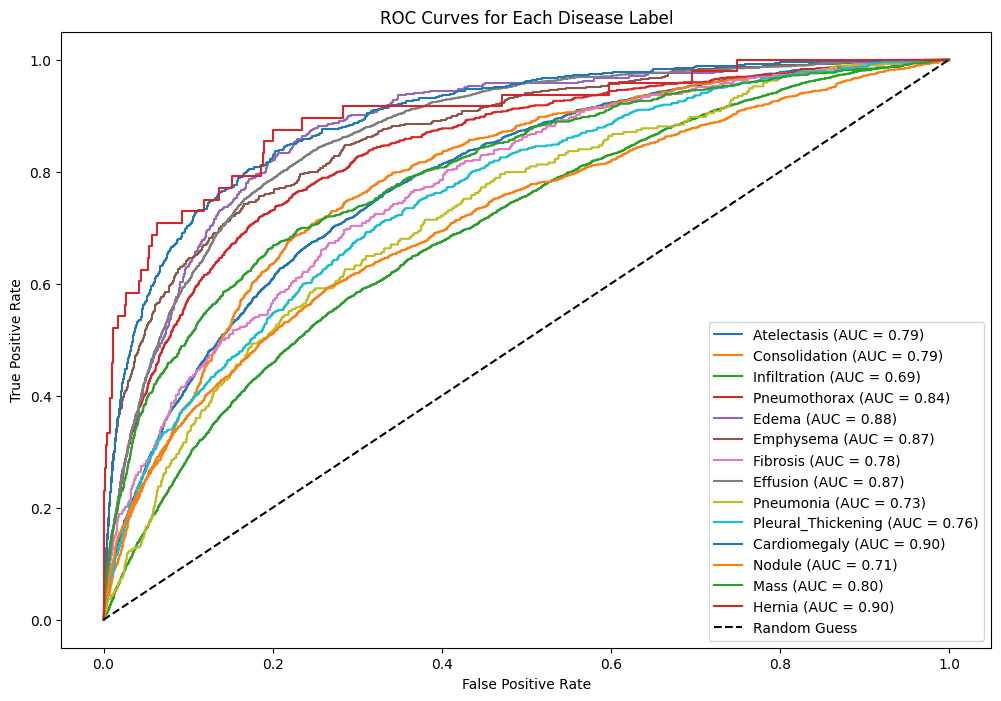

In [23]:
# Plot ROC curves
plt.figure(figsize=(12, 8))
for i, label in enumerate(disease_labels):
    fpr, tpr, _ = roc_curve(labels[:, i], preds[:, i])
    plt.plot(fpr, tpr, label=f"{label} (AUC = {roc_auc_per_label[label]:.2f})")

plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Each Disease Label')
plt.legend(loc='lower right')
plt.show()

**Plot Training and Validation Loss**

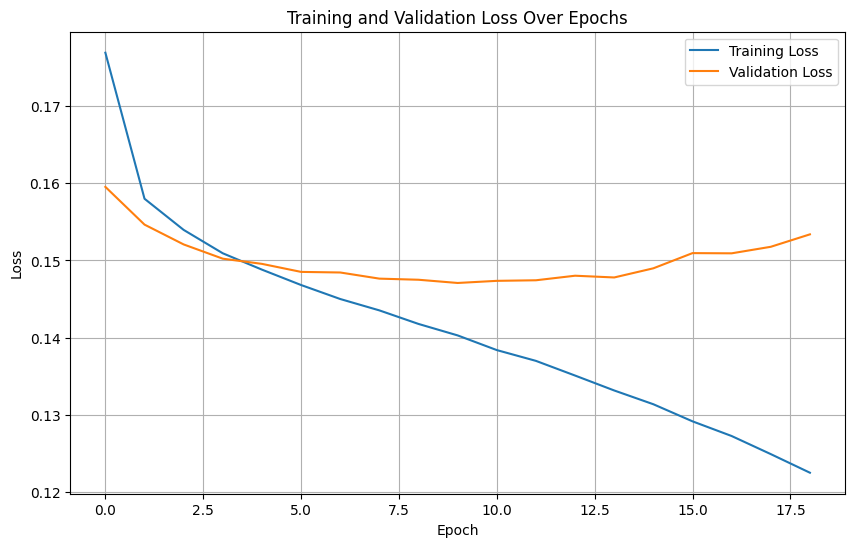

In [24]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

**Plot Validation AUC**

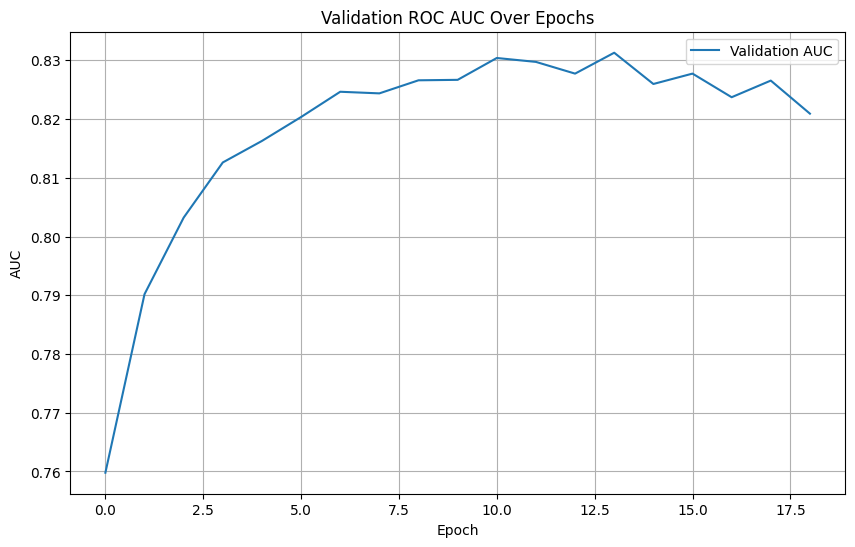

In [25]:
plt.figure(figsize=(10, 6))
plt.plot(val_aucs, label='Validation AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.title('Validation ROC AUC Over Epochs')
plt.legend()
plt.grid(True)
plt.show()